# Ensemble Learning
A group of predictors is called an _ensemble_  
Random Forest is an ensemble of decision trees. Despite its simplicity its one of the most powerful machine learning algo.  
An ensemble learning algo is call _Ensemble method_

ex: an ensemble of decision tree classifiers are trained on different subsets of training data, then while prediction, each one predicts a class and then the prediction with most votes be the final prediction

### Why ensemble is better than one single expert algorithm with high accuracy?   
_The law of large numbers_ : as we increase the number of trials of an experiment, the ratio of outcomes starts to match the original probability despite the factor of randomness.  
ex: lets say we have a biased coin 51% head, 49% tails. the first 1000 may get 510 heads,490 tails, but still practically there is randomness and hence the probability that we will get _more number of heads than tails_ is about 75%, but as we increase the trails, this probability of _getting more number of heads than tails_ increases, at 10000 trails it becomes _97%_ 

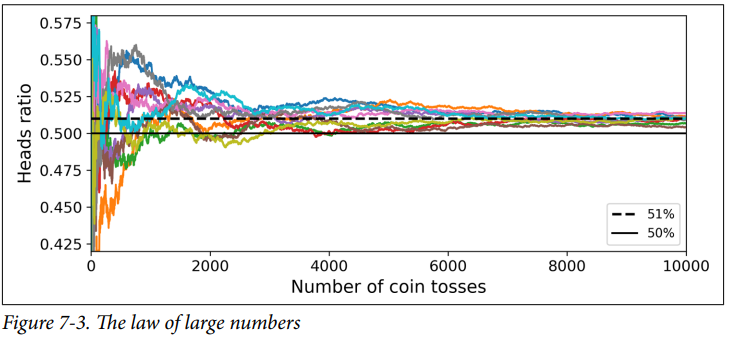

similarily, if we have 1000 weak classifiers with accuracy only 51% (meaning that they are correct about 51% of times). After ensembling them, we can get about 75% of accuracy. 97% accuracy if we have 10000 classifiers  

(This is just ex we are not training 10000 classifiers ever)

### The problem with ensemble
Ensemble methods works best when predictors are _independent_ from each other (being independent means that the errors of each base learner (predictor) are different and not correlated to each other)

Either the datasets on which each model is trained is different or each model itself is different fundamentally

why??   
If we have similar or correlated errors in ensemble, they will combine and error may increase in final model  
If we have different or independent errors in ensemble, they will cancel each oterh out and lead to more accurate overall model

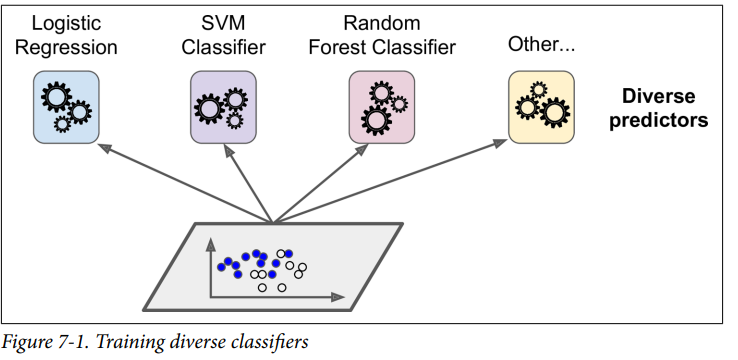

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Make moons dataset is used for classification problems
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x,y = make_moons(n_samples=500,noise=0.3,random_state=42)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr',LogisticRegression(random_state=42)),
        ('svc',SVC(random_state=42)),
        ('rf',RandomForestClassifier(random_state=42))
    ],
    voting='hard'   #Two types of voting - Hard or soft 
)

voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [22]:
from sklearn.metrics import accuracy_score
for name, clf in zip([name for name, _ in voting_clf.estimators], voting_clf.estimators_):
    print(name, "=", accuracy_score(y_test,y_pred=clf.predict(x_test)))
print('ensemble score',accuracy_score(y_test,voting_clf.predict(x_test)))

lr = 0.864
svc = 0.896
rf = 0.896
ensemble score 0.912


In [23]:
## Using 'voting = soft' (estimator must have 'predict_proba' or 'probability' function for soft voting)

voting_clf.voting = 'soft'
voting_clf.named_estimators['svc'].probability = True 
voting_clf.fit(x_train,y_train)
voting_clf.score(x_test,y_test)

0.92

(These are only 2-3 model ensemble, and data is not so complex, additionally these models work great individually so ensemble doesnt really help much) (We will see complex things soon)

## Bagging and Pasting

To make a good ensemble we need predictors to be independent.    

__How?__  
- By using very different training algorithms
- By using same algorithm on different subsets of training data

In _bagging_ and _pasting_ we apply the second concept!  
Here, we train same algorithms but on different subsets of training data.  

__Whats the difference?__   
_replacement_ : While randomly selecting a sample for base predictor, we put the sample back to training data before selecting another sample. Hence, each predictor usually have same size as training data but with different repeated samples (which makes each model unique).  


- In bagging (bootsrap aggregator) we do _replacement_
- In pasting we do not do _replacement_

In pasting, Each model sees a different subset of data, with no repeated samples in that subset. 

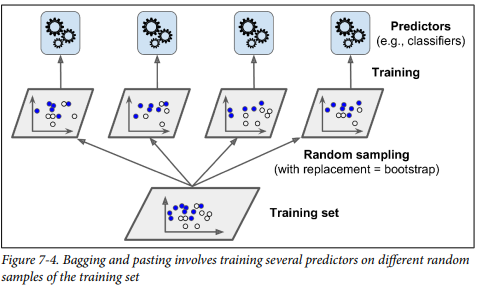

___Note___  
- The aggregation function is basically just _statistical mode_ of output for classifiers and 
_average_ for regressors

- Generally the net result is that, ensemble has similar _bais_ compared to best individual model but much less _variance_ 

- Base Predictors can be trained on different cores of CPU and similarly prediction can be done in parallel. This make the model scale very well

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

## Using 100 decision trees to ensemble one Bagging classifier
bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100, 
    bootstrap=True,    #Bootstrap=False for PASTING
    random_state=42,
    n_jobs=-1          #n_jobs = number of cores to be used while training (-1 -> use all cores)
)

bag_clf.fit(x_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=100, n_jobs=-1, random_state=42)

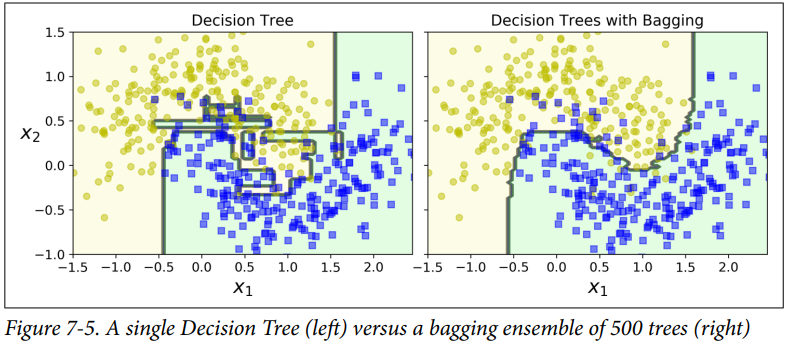

### Out of Bag Evaluation
In bagging, for each estimator, some samples get drawn several times to train the estimator and there are some samples that estimator do not see at all. When using 'm' (size of training set) samples to train the estimator in bootsrap=True, there are about 63% samples on which estimator is trained hence there are 37% samples that estimator do not see at all.   

Those 37% samples are call _out of bag_ samples. And they can be used to evaluate the estimator. This removes the need of using validation set. And this is call __Out Of Bag Evaluation__ or __OOB__, We can evaluate the ensemble by averaging oob score.

Note - those 37% samples are different for each base estimator



In [34]:
bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    oob_score=True      #To get the oob score
)

bag_clf.fit(x_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)

In [35]:
print('OOB score',bag_clf.oob_score_)
print('accuracy score',accuracy_score(y_test,bag_clf.predict(x_test)))

OOB score 0.8933333333333333
accuracy score 0.896


In [38]:
## Since the base estimator (DecisionTree) has predict_proba method
## We can see decision function using oob_decision_function_
## The decision function returns class probabilities for each instance
bag_clf.oob_decision_function_[:3]  #showing only for first 3 instances 

array([[0.3902439, 0.6097561],
       [0.2173913, 0.7826087],
       [1.       , 0.       ]])

## Random Patches and Random Subspaces
Similarily, we can sample the _features_ of data too.  

- Sampling both features and training instances is called _Random Patches_
- Sampling features only and keeping bootstrap=False, max_samples =1.0(whole data) (i.e No sampling of training instances) is called _Random subspaces_

Sampling features results in even more predictor diversity, trading a bit more bias for
a lower variance.


In [41]:
random_patch = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    bootstrap=True,
    max_samples=100, 
    max_features=1.0,           #this   
    bootstrap_features=True,     #And this handles random patches and random subspaces
    random_state=42,
    n_jobs=-1,
    oob_score=True 
)

random_patch.fit(x_train,y_train)

BaggingClassifier(bootstrap_features=True,
                  estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=100, n_jobs=-1, oob_score=True,
                  random_state=42)

## Random Forest
- Ensemble of decision trees.
- Usually based on bagging (sometimes pasting)
- RandomForest class in sklearn provides almost all hyperparameters of decision tree and bagging both

In [49]:
from sklearn.ensemble import RandomForestClassifier

# This code trains 500 trees with all available cpu cores, each tree with max number of leaf nodes = 16
random_forest = RandomForestClassifier(n_estimators=500,bootstrap=True,max_leaf_nodes=16,
                                       n_jobs=-1,random_state=42,oob_score=True)

random_forest.fit(x_train,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [45]:
random_forest.oob_score_

0.9173333333333333

RandomForest introduces extra randomness in splitting of tree, instead of splitting root node from very best feature, it searches for best node among the random subset of features. This increases the diversity in trees

This again trades higher bias for lower variance but overall gives a better model

## Extra-Trees (Extremely Randomized Trees)
Instead of searching for best threshold for each feature in each decision tree, We can make randomforest even more random by randomly selecting the thresholds for each features. 
- This will again trade higher bais for lower variance
- This reduces computational expense significantly since searching for best threshold for each feature at every node of every decision tree is one of the most time taking task in growing the tree

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree = ExtraTreesClassifier(n_estimators=500,bootstrap=True,n_jobs=-1,random_state=42,oob_score=True)
extra_tree.fit(x_train,y_train)

ExtraTreesClassifier(bootstrap=True, n_estimators=500, n_jobs=-1,
                     oob_score=True, random_state=42)

In [51]:
extra_tree.oob_score_

0.9013333333333333

___Note___  
- It is difficult to say which one performs better Extra Trees or RandomForest. One way to decide is train both and then compare using cross validation

### Feature Importance
Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest)

Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1

In [57]:
from sklearn.datasets import load_iris
data = load_iris()
iris_x, iris_y = data.data, data.target

random_forest = RandomForestClassifier(n_estimators=500,n_jobs=-1)
random_forest.fit(iris_x,iris_y)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [59]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [60]:
for feature_name, feature_imp in zip(data.feature_names,random_forest.feature_importances_):
    print(feature_name, feature_imp)

sepal length (cm) 0.10060674808570627
sepal width (cm) 0.023081330257368065
petal length (cm) 0.4265384858221307
petal width (cm) 0.44977343583479484


clearly petal length and petal width are most important

- ___`Random Forest are very handy in feature selection`___